In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
print(dataset_train.head())

# To create a numpy array we select the column and add .values
# Neural networks can only accept numpy array as input
training_set = dataset_train.iloc[:, 1:2].values
print('\n')
training_set

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800




array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [2]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
# All our scaled values will be between 0 and 1
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [3]:
# Creating a data structure with 60 timesteps and 1 output
# Look at the 60 timesteps in the past to get a trend, learn by trial and error
X_train = []
y_train = []
# Start from 60th day and go to 1257 which must be written as 1258
# Memorize the first 60 values to predict the 61st price
# If you use the range fuction for example range(1,5) then the models stops at 4
for i in range(60, 1258):
  # example when i = 60, [60-60:60,0]
  # Implies [0:60,0]
  # Data is indexed from 0 so it stops at 59th timestep
    X_train.append(training_set_scaled[i-60:i, 0])
    # the value of i = 60 in the beginning
    y_train.append(training_set_scaled[i, 0])


In [4]:
# X_train and Y_train are list and have to converted to np.array
# Only Numpy Array can be fed into DNN function
# X_Train :check the row. It has 60 past value
X_train, y_train = np.array(X_train), np.array(y_train)
print(len(y_train)) # 1258 - 60 = 1198

# Reshaping
# To add a dimension to numpy array we must use numpy array
# In Python shape() is used in pandas to give number of row(0)/column(1)
# RNN accepts 3D tensor with shape (batch_size, timesteps, input_dim)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

1198


In [5]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
# Regressor - predicting a continuous value like stock price so doing regression
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
# Return_sequences = True because we are going to add another LTSM
# Input_Shape: Input only timesteps and indicator
# the data set X_train.shape[0] will be taken automatically
# The input data is always 3D as required by Keras and discussed
# Rate of neurons to drop in a LTSM layer during each iteration of the training
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
# return_sequences = False so dropped return_sequences as default is False
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer and connecting a fully connected layer
regressor.add(Dense(units = 1))

# Compiling the RNN
# Loss is MSE as we are doing regression and not classification
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
38/38 [==============================] - 10s 17ms/step - loss: 0.0501
Epoch 2/100
38/38 [==============================] - 1s 17ms/step - loss: 0.0071
Epoch 3/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0056
Epoch 4/100
38/38 [==============================] - 1s 15ms/step - loss: 0.0056
Epoch 5/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0057
Epoch 6/100
38/38 [==============================] - 1s 16ms/step - loss: 0.0052
Epoch 7/100
38/38 [==============================] - 1s 17ms/step - loss: 0.0046
Epoch 8/100
38/38 [==============================] - 1s 15ms/step - loss: 0.0047
Epoch 9/100
38/38 [==============================] - 1s 15ms/step - loss: 0.0043
Epoch 10/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0044
Epoch 11/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0048
Epoch 12/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0041
Epoch 13/100
38/38 [====

In [6]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

# Getting the predicted stock price of 2017
# Some stock price will come from 2016 and some from January 2017
# We will need to concatenate all the "Open" stock prices nothing else
# Concat along vertical axis set Axis = 0
# Our RNN was trained on scaled input so data set has to be scaled
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

# First financial day of 2017 - is 3rd January
# We need the first stock price for Jan 2017 upto the last stock price-1 for Jan 2017
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

# the inputs are not in the form we expected because we have not used the iloc function
# we have provided column as 1 but rows are unknown which is set to -1 
# python on seeing -1 will try to find out the number of rows
# check what reshape(1,-1) means 
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

# we are only doing prediction so only keep x_test
X_test = []
# test set only has 20 days so upper bound is 60+20 = 80
for i in range(60, 80):
    # range in append is taken from the inputs data set created 
    X_test.append(inputs[i-60:i, 0])

## Outside the for loop
X_test = np.array(X_test)

# 3D structure is needed as per Keras (seen earlier too)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = regressor.predict(X_test)
# Get original scale so apply inverse transform
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


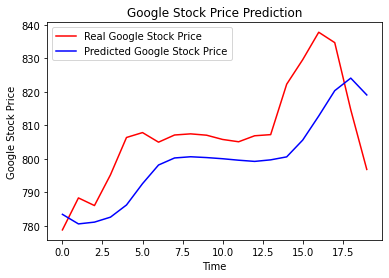

In [7]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()
